## DIA 009: Gradient Boosting para Clasificación

El Gradient Boosting es una técnica de aprendizaje supervisado que construye modelos predictivos de manera secuencial, donde cada nuevo modelo intenta corregir los errores del anterior. A diferencia de los Bosques Aleatorios, que entrenan múltiples árboles de decisión de forma independiente, el Gradient Boosting entrena árboles de decisión de manera aditiva, enfocándose en las áreas donde el modelo previo tuvo un desempeño deficiente.

Características clave del Gradient Boosting:

- Ensemble Learning: Combina múltiples modelos débiles (árboles de decisión) para formar un modelo fuerte.
- Aprendizaje Secuencial: Cada nuevo árbol se entrena para corregir los errores residuales del conjunto anterior.
- Flexibilidad: Puede optimizar diferentes funciones de pérdida y adaptarse a diversos tipos de datos.
- Importancia de las Características: Al igual que en Random Forests, permite identificar qué variables son más relevantes para las predicciones.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import joblib

# 1. Cargar el dataset
df = pd.read_csv('titanic.csv')

In [33]:
# 2. Exploración inicial
print("Primeras filas del dataset:")
print(df.head())

print("\nInformación general:")
print(df.info())

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nEstadísticas descriptivas:")
print(df.describe())

Primeras filas del dataset:
   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 no

In [34]:
# 3. Selección de características relevantes
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

df_selected = df[features + [target]]

In [35]:
# 4. Manejo de valores nulos
df_selected['Age'].fillna(df_selected['Age'].median(), inplace=True)
df_selected['Embarked'].fillna(df_selected['Embarked'].mode()[0], inplace=True)

print("\nValores nulos después de la imputación:")
print(df_selected.isnull().sum())


Valores nulos después de la imputación:
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Survived    0
dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13248\3499508621.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_selected['Age'].fillna(df_selected['Age'].median(), inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13248\3499508621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Age'].fillna(df_selected['Age'].med

In [36]:
# 5. Conversión de variables categóricas en numéricas
df_selected['Sex'] = df_selected['Sex'].map({'male': 0, 'female': 1})
df_selected = pd.get_dummies(df_selected, columns=['Embarked'], drop_first=True)

print("\nPrimeras filas después del preprocesamiento:")
print(df_selected.head())


Primeras filas después del preprocesamiento:
   Pclass  Sex   Age  SibSp  Parch     Fare  Survived  Embarked_Q  Embarked_S
0       3    0  22.0      1      0   7.2500         0       False        True
1       1    1  38.0      1      0  71.2833         1       False       False
2       3    1  26.0      0      0   7.9250         1       False        True
3       1    1  35.0      1      0  53.1000         1       False        True
4       3    0  35.0      0      0   8.0500         0       False        True


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13248\3193774142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Sex'] = df_selected['Sex'].map({'male': 0, 'female': 1})


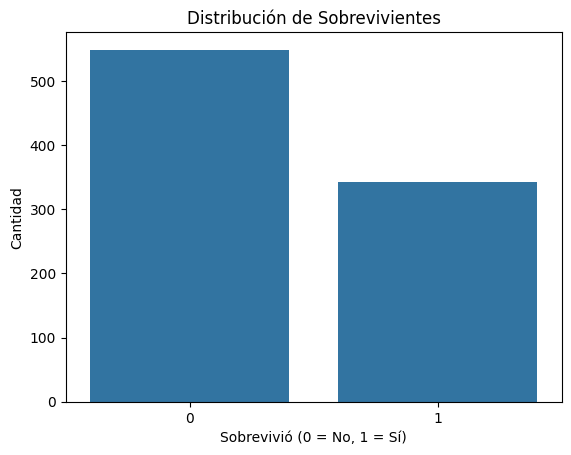

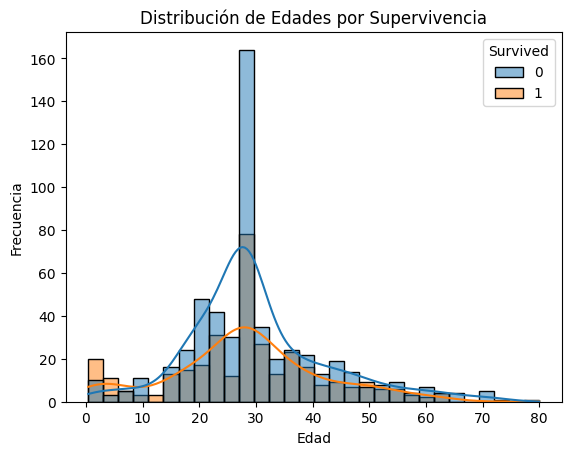

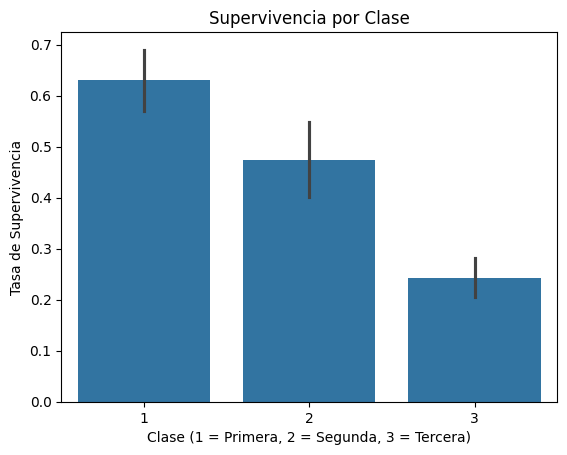

In [37]:
# 6. Visualización de datos
# Distribución de sobrevivientes
sns.countplot(x='Survived', data=df_selected)
plt.title('Distribución de Sobrevivientes')
plt.xlabel('Sobrevivió (0 = No, 1 = Sí)')
plt.ylabel('Cantidad')
plt.show()

# Distribución de edades por supervivencia
sns.histplot(data=df_selected, x='Age', hue='Survived', kde=True, bins=30)
plt.title('Distribución de Edades por Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

# Relación entre clase y supervivencia
sns.barplot(x='Pclass', y='Survived', data=df_selected)
plt.title('Supervivencia por Clase')
plt.xlabel('Clase (1 = Primera, 2 = Segunda, 3 = Tercera)')
plt.ylabel('Tasa de Supervivencia')
plt.show()

In [38]:
# 7. Preparación de los datos para el modelo
X = df_selected.drop('Survived', axis=1)
y = df_selected['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'\nTamaño del conjunto de entrenamiento: {X_train.shape[0]}')
print(f'Tamaño del conjunto de prueba: {X_test.shape[0]}')


Tamaño del conjunto de entrenamiento: 712
Tamaño del conjunto de prueba: 179


In [39]:
# 8. Entrenamiento del modelo de Gradient Boosting con LightGBM
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


LGBMClassifier(random_state=42)

In [40]:
# 9. Predicciones
y_pred = lgbm.predict(X_test)
y_pred_prob = lgbm.predict_proba(X_test)[:,1]

print("\nPredicciones en el conjunto de prueba:")
print(y_pred[:10])



Predicciones en el conjunto de prueba:
[0 0 0 1 1 1 1 0 1 1]



Precisión del modelo: 0.83


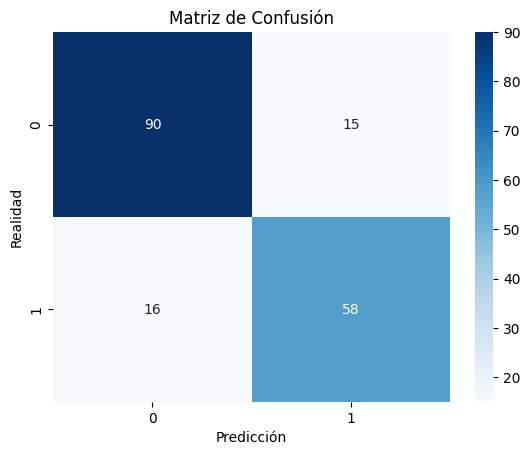


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       105
           1       0.79      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



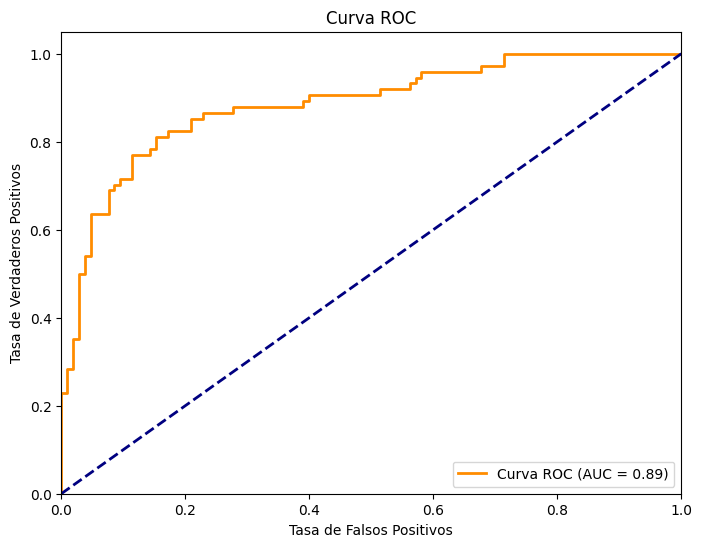

In [41]:
# 10. Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'\nPrecisión del modelo: {accuracy:.2f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


Importancia de las características:
      Feature  Importancia
5        Fare         1198
2         Age         1020
0      Pclass          104
7  Embarked_S          102
1         Sex           97
3       SibSp           92
4       Parch           65
6  Embarked_Q           31


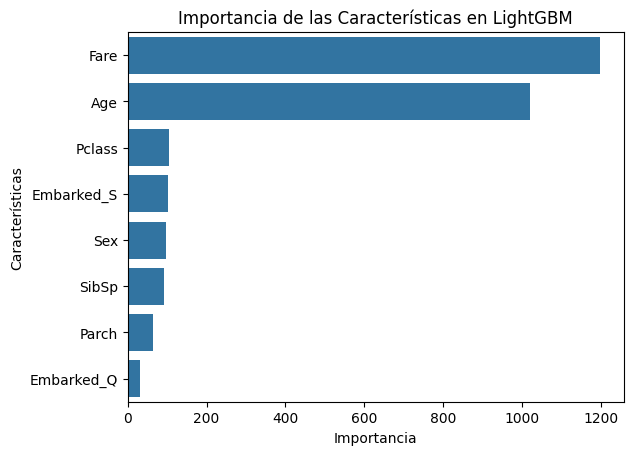

In [42]:
# 11. Interpretación de la Importancia de las Características
# Importancia de las características
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': lgbm.feature_importances_
}).sort_values(by='Importancia', ascending=False)

print("\nImportancia de las características:")
print(feature_importances)

# Visualizar la importancia
sns.barplot(x='Importancia', y='Feature', data=feature_importances)
plt.title('Importancia de las Características en LightGBM')
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.show()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

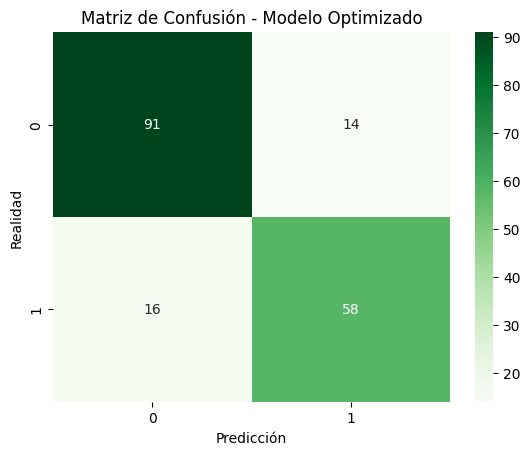


Reporte de Clasificación - Modelo Optimizado:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



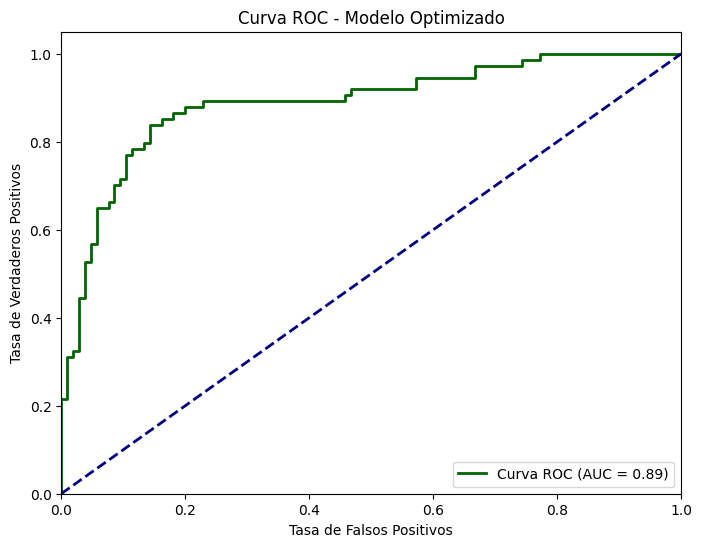

In [43]:
# 12. Optimización del Modelo con Grid Search
# Definir el rango de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Instanciar el modelo
lgbm = LGBMClassifier(random_state=42)

# Grid Search con validación cruzada de 5 folds
grid_search = GridSearchCV(
    estimator=lgbm, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)
grid_search.fit(X_train, y_train)

# Mejor combinación de parámetros
print(f'\nMejores parámetros: {grid_search.best_params_}')
print(f'Mejor precisión en validación cruzada: {grid_search.best_score_:.2f}')

# Entrenar el modelo con los mejores parámetros
best_lgbm = grid_search.best_estimator_
y_pred_best = best_lgbm.predict(X_test)
y_pred_prob_best = best_lgbm.predict_proba(X_test)[:,1]

# Evaluar el modelo optimizado
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f'\nPrecisión del modelo optimizado: {accuracy_best:.2f}')

# Matriz de confusión optimizada
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - Modelo Optimizado')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Reporte de clasificación optimizado
print("\nReporte de Clasificación - Modelo Optimizado:")
print(classification_report(y_test, y_pred_best))

# Curva ROC y AUC optimizada
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_pred_prob_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8,6))
plt.plot(fpr_best, tpr_best, color='darkgreen', lw=2, label=f'Curva ROC (AUC = {roc_auc_best:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo Optimizado')
plt.legend(loc='lower right')
plt.show()

In [44]:
# 13. Guardar el Modelo Optimizado
joblib.dump(best_lgbm, 'lightgbm_titanic.pkl')
print("\nModelo de LightGBM guardado como 'lightgbm_titanic.pkl'")


Modelo de LightGBM guardado como 'lightgbm_titanic.pkl'
